In [1]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
data = hddm.load_csv("data_actions.csv")

In [3]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [4]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':"", 'score': 0}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    act_df["score"] = rating
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [5]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
## Adjusting weights for actions
actions["type_adj"] = ""
actions["score_adj"] = 0

for index, row in actions.iterrows():
    score = sum(row[0:10] * [4,-4,0,-4,4,0,0,-4,4,0])
    actions.iloc[index, 15] = score
    actions.iloc[index, 14] = "Pro-social" if score>=0 else "Pro-self"
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,score,type,user,treatment,type_adj,score_adj
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,64.0,Pro-social,s3m7_usuario9,weak,Pro-self,-28.0
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,78.0,Pro-social,s3m7_usuario18,weak,Pro-social,32.0
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario7,weak,Pro-social,4.0
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario10,weak,Pro-social,4.0
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,98.0,Pro-social,s3m7_usuario13,weak,Pro-social,0.0
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario5,weak,Pro-social,8.0
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,90.0,Pro-social,s3m7_usuario15,weak,Pro-social,0.0
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,90.0,Pro-social,s3m7_usuario16,weak,Pro-social,4.0
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,82.0,Pro-social,s3m7_usuario12,weak,Pro-self,-16.0
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,90.0,Pro-social,s3m7_usuario6,weak,Pro-social,20.0


In [3]:
actions = pd.read_csv("actions.csv")
actions

,Unnamed: 0,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,...,score80,score_adj80,self80,other80,self90,other90,score100,score_adj100,self100,other100
0,0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
1,1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
2,2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
3,3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
4,4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
5,5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
6,6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
7,7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
8,8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0
9,9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,...,10,0,3.0,3.0,3.0,3.0,10,0,3.0,3.0


In [7]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")
data_svo.opponent = data_svo['opponent'].str.strip("['']")

In [8]:
data_svo

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,type,user
0,0,1,s3m7_usuario9,D,s3m7_usuario18,C,4,-4.452,s3m7,weak,00D,0,4.452,Pro-social,s3m7_usuario9
1,18,2,s3m7_usuario9,C,s3m7_usuario18,C,3,5.401,s3m7,weak,DCC,1,5.401,Pro-social,s3m7_usuario9
2,36,3,s3m7_usuario9,D,s3m7_usuario18,C,4,-10.751,s3m7,weak,CCD,0,10.751,Pro-social,s3m7_usuario9
3,54,4,s3m7_usuario9,C,s3m7_usuario18,C,3,3.443,s3m7,weak,DCC,1,3.443,Pro-social,s3m7_usuario9
4,72,5,s3m7_usuario9,C,s3m7_usuario18,C,3,6.401,s3m7,weak,CCC,1,6.401,Pro-social,s3m7_usuario9
5,90,6,s3m7_usuario9,D,s3m7_usuario18,C,4,-5.265,s3m7,weak,CCD,0,5.265,Pro-social,s3m7_usuario9
6,108,7,s3m7_usuario9,C,s3m7_usuario18,D,0,5.641,s3m7,weak,DCC,1,5.641,Pro-social,s3m7_usuario9
7,126,8,s3m7_usuario9,D,s3m7_usuario18,C,4,-10.555,s3m7,weak,CDD,0,10.555,Pro-social,s3m7_usuario9
8,144,9,s3m7_usuario9,C,s3m7_usuario18,C,3,10.590,s3m7,weak,DCC,1,10.590,Pro-social,s3m7_usuario9
9,162,10,s3m7_usuario9,D,s3m7_usuario18,D,0,-7.549,s3m7,weak,CCD,0,7.549,Pro-social,s3m7_usuario9


# Changing

In [9]:
chang = data_svo[data_svo.treatment == "changing"]
chang["type"].value_counts()

Pro-self      7500
Pro-social    2100
Name: type, dtype: int64

In [19]:
## trying a model per subject, with the whole dataset, then partitioning afterwards

params_chang = actions.loc[actions.treatment == "changing", ["user", "type", "score", "type_adj", "score_adj"]]
params_chang["a"] = 0
params_chang["v"] = 0
params_chang["t"] = 0
params_chang["z"] = 0
params_chang

modeler = ddm.HDDMmodelMaker()
for s in chang.player.unique():
    model_soc_s3 = modeler.fit_model(chang.loc[(chang["player"] == s)], 5000, 200)
    params_chang.loc[params_chang.user == s, ["a","v","t","z"]] = model_soc_s3.gen_stats()["mean"].values
    

 [-----------------100%-----------------] 5000 of 5000 complete in 6.8 secc

In [20]:
params_chang["y"] = 0
params_chang["y_adj"] = 0
params_chang.loc[params_chang["type"] == "Pro-social", ["y"]] = 1
params_chang.loc[params_chang["type"] == "Pro-self", ["y"]] = 0
params_chang.loc[params_chang["type_adj"] == "Pro-social", ["y_adj"]] = 1
params_chang.loc[params_chang["type_adj"] == "Pro-self", ["y_adj"]] = 0
chang_df = params_chang[["a","v", "t", "z", "y"]]
chang_df

,a,v,t,z,y
76,2.950889,0.014763,0.590452,0.470343,0
77,3.829557,-0.160750,0.355562,0.296928,0
78,2.476410,0.102665,0.447284,0.597854,1
79,1.778156,-0.190221,0.544970,0.499876,0
80,3.864462,-0.010799,0.593348,0.599866,1
81,4.612981,-0.511692,0.802654,0.291222,0
82,2.796945,0.383604,0.257409,0.631781,1
83,2.772482,0.397674,0.743277,0.406362,1
84,3.364493,-0.275819,0.611345,0.483899,0
85,3.474727,-0.135503,0.368234,0.413130,0


In [23]:
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(chang_df[["a","v", "t", "z"]], chang_df[["y"]], test_size=0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape


(67, 4) (67, 1)
(29, 4) (29, 1)


In [24]:
## Test with logistic regression
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
model = LogisticRegression()

In [25]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 6-fold cross validation
scores = cross_val_score(model, chang_df[["a","v", "t", "z"]], chang_df[["y"]], cv=10)
print ("Cross-validated scores:", scores)

('Cross-validated scores:', array([0.81818182, 1.        , 0.8       , 0.9       , 0.8       ,
       0.88888889, 0.77777778, 0.77777778, 0.88888889, 1.        ]))


/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(model, X_test, y_test, cv=10)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/sklearn/model_selection/_split.py:651: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([[23,  0],
       [ 6,  0]])

In [27]:
from sklearn import svm
clf = svm.SVC()

# Perform 6-fold cross validation
scores = cross_val_score(clf, chang_df[["a","v", "t", "z"]], chang_df[["y"]], cv=10)
print ("Cross-validated scores:", scores)

('Cross-validated scores:', array([0.81818182, 0.9       , 0.8       , 0.9       , 0.8       ,
       0.88888889, 0.77777778, 0.77777778, 0.88888889, 0.88888889]))


/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/daal4py/sklearn/svm/svm.py:321: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [10]:
rounds_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for w in rounds_windows:
    params_chang["a_st%d" % w] = 0
    params_chang["v_st%d" % w] = 0
    params_chang["t_st%d" % w] = 0
    params_chang["z_st%d" % w] = 0
    modeler = ddm.HDDMmodelMaker()
    for s in chang.player.unique():
        model_soc_s3 = modeler.fit_model(chang.loc[(chang["player"] == s) & (chang["round"] <= w) & (chang["round"] > (w - 9))], 5000, 200)
        params_chang.loc[params_chang.user == s, ["a_st%d" % w,"v_st%d" % w,"t_st%d" % w,"z_st%d" % w]] = model_soc_s3.gen_stats()["std"].values

 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 sec

In [13]:

params_chang.to_csv("params_chang.csv")

In [31]:
for r in rounds_windows:
    X, y = params_chang[["a%d" % r,"v%d" % r, "t%d" % r, "z%d" % r]], params_chang[["y"]]
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, cv=10)
    print ("Cross-validated scores %d: %f, %f" % (r,np.mean(scores), np.std(scores)))

Cross-validated scores 10: 0.802727, 0.070557
Cross-validated scores 20: 0.802727, 0.050091
Cross-validated scores 30: 0.822929, 0.047283
Cross-validated scores 40: 0.834040, 0.048409
Cross-validated scores 50: 0.822929, 0.047283
Cross-validated scores 60: 0.832929, 0.051741
Cross-validated scores 70: 0.832929, 0.051741
Cross-validated scores 80: 0.865152, 0.063231
Cross-validated scores 90: 0.865152, 0.080420


In [33]:
for r in rounds_windows:
    X, y = params_chang[["a%d" % r,"v%d" % r, "t%d" % r, "z%d" % r]], params_chang[["y_adj"]]
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, cv=10)
    print ("Cross-validated scores %d: %f, %f" % (r,np.mean(scores), np.std(scores)))

Cross-validated scores 10: 0.723232, 0.146252
Cross-validated scores 20: 0.778788, 0.134874
Cross-validated scores 30: 0.850505, 0.122950
Cross-validated scores 40: 0.859596, 0.123584
Cross-validated scores 50: 0.881818, 0.105559
Cross-validated scores 60: 0.883838, 0.093482
Cross-validated scores 70: 0.913131, 0.108622
Cross-validated scores 80: 0.904040, 0.104705
Cross-validated scores 90: 0.904040, 0.104705


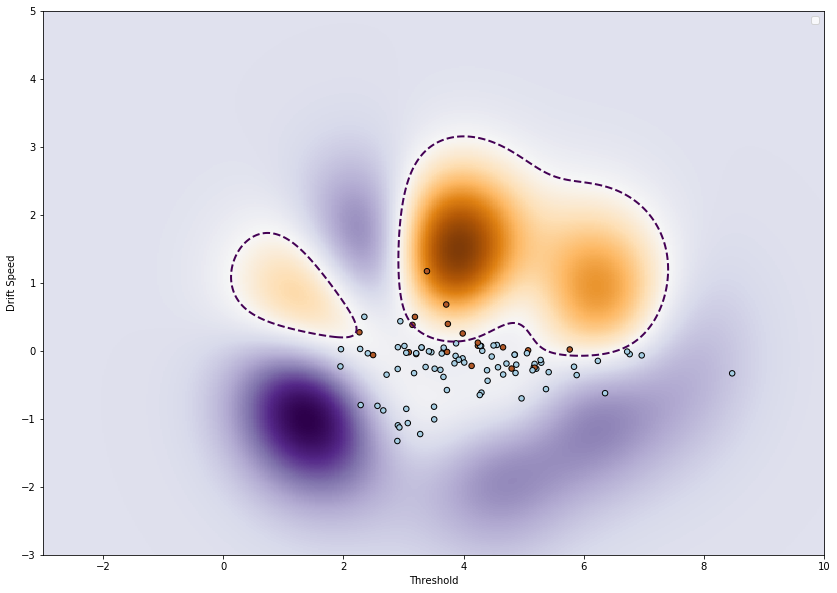

In [42]:
X, y = params_chang[["a20","v20"]], params_chang[["y"]]
xx, yy = np.meshgrid(np.linspace(-3, 10, 500),
                     np.linspace(-3, 5, 500))
model = svm.SVC(kernel='rbf', C=1000)
model.fit(X,y)
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (14, 10))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linestyles='dashed')
plt.scatter(X[["a20"]], X[["v20"]], s=30, c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xlabel("Threshold")
plt.ylabel("Drift Speed")
plt.legend()
#plt.xticks(())
#plt.yticks(())
#plt.axis([-3, 3, -3, 3])
plt.show()

In [19]:
matched = actions.loc[actions["type"] == actions["type_adj"], "user"].values
unmatched = actions.loc[actions["type"] != actions["type_adj"], "user"].values
socials = actions.loc[actions["type"] == "Pro-social", "user"].values
selfs =  actions.loc[actions["type"] == "Pro-self", "user"].values

a_matched = pd.melt(params_chang.loc[params_chang.user.isin(matched)], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])
a_unmatched = pd.melt(params_chang.loc[params_chang.user.isin(unmatched)], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])


a_socials = pd.melt(params_chang.loc[params_chang.user.isin(socials)], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])
a_selfs = pd.melt(params_chang.loc[params_chang.user.isin(selfs)], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])

a_un_socials = pd.melt(params_chang.loc[params_chang.user.isin(set(socials).intersection(set(unmatched)))], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])
a_un_selfs = pd.melt(params_chang.loc[params_chang.user.isin(set(selfs).intersection(set(unmatched)))], id_vars=['user'], value_vars=["a10","a20","a30","a40","a50","a60","a70","a80","a90"])


['a10', 'a20', 'a30', 'a40', 'a50', 'a60', 'a70', 'a80', 'a90', 'a100']

In [15]:
#Receives a list of players to show
def get_params(param, players, treatment = "chang", column2 = None):
    param_cols = ["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]
    param_sd = ["%s_st%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])] 
    params = pd.melt(params_chang.loc[params_chang.user.isin(players)], id_vars=['user'], value_vars = param_cols)
    sds = pd.melt(params_chang.loc[params_chang.user.isin(players)], id_vars=['user'], value_vars = param_sd)
    d = params.groupby("variable").mean()
    d.index = pd.to_numeric(d.index.str.replace(param, ""))
    d_sd = sds.groupby("variable").mean()
    d_sd.index = pd.to_numeric(d_sd.index.str.replace("%s_st" % (param), ""))
    d_sd["round"] = d_sd.index
    d["round"] = d.index
    d = d.merge(d_sd, on = "round")
    d = d.sort_values(by="round")
    d.rename(columns = {"value_x":param, "value_y":"std"}, inplace=True)
    return d

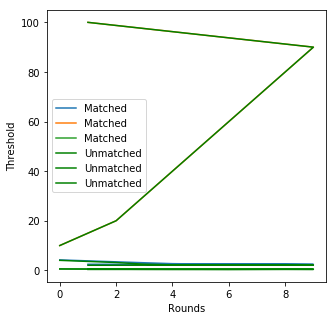

In [16]:
matched = actions.loc[actions["type"] == actions["type_adj"], "user"].values
unmatched = actions.loc[actions["type"] != actions["type_adj"], "user"].values

plt.figure(figsize=(5,5))
plt.plot(get_params("a", matched), label = "Matched")
plt.plot(get_params("a", unmatched), label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.legend()

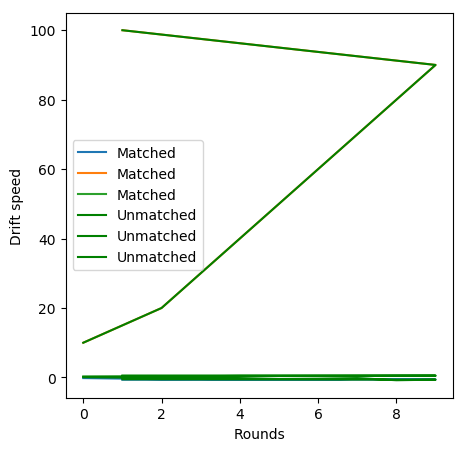

In [18]:
plt.figure(figsize=(5,5))
plt.plot(get_params("v", matched), label = "Matched")
plt.plot(get_params("v", unmatched), label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Drift speed")
plt.legend()

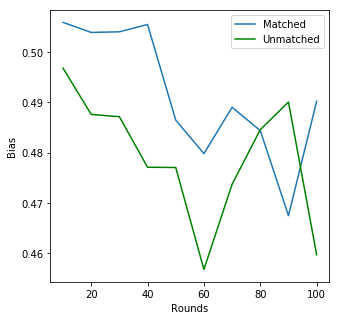

In [64]:
plt.figure(figsize=(5,5))
plt.plot(get_params("z", matched), label = "Matched")
plt.plot(get_params("z", unmatched), label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Bias")
plt.legend()

In [22]:

v_matched = pd.melt(params_chang.loc[params_chang.user.isin(matched)], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])
v_unmatched = pd.melt(params_chang.loc[params_chang.user.isin(unmatched)], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])

v_socials = pd.melt(params_chang.loc[params_chang.user.isin(socials)], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])
v_selfs = pd.melt(params_chang.loc[params_chang.user.isin(selfs)], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])

v_un_socials = pd.melt(params_chang.loc[params_chang.user.isin(set(socials).intersection(set(unmatched)))], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])
v_un_selfs = pd.melt(params_chang.loc[params_chang.user.isin(set(selfs).intersection(set(unmatched)))], id_vars=['user'], value_vars=["v10","v20","v30","v40","v50","v60","v70","v80","v90"])

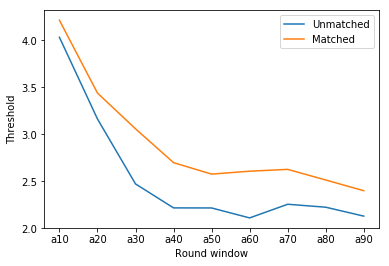

In [23]:
plt.plot(a_unmatched.groupby("variable").mean(), label = "Unmatched")
plt.plot(a_matched.groupby("variable").mean(),  label = "Matched")
plt.xlabel("Round window")
plt.ylabel("Threshold")
plt.legend()

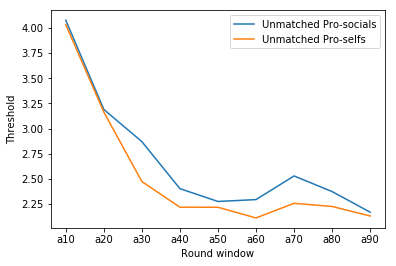

In [24]:
plt.plot(a_socials.groupby("variable").mean(), label = "Unmatched Pro-socials")
plt.plot(a_un_selfs.groupby("variable").mean(),  label = "Unmatched Pro-selfs")
plt.xlabel("Round window")
plt.ylabel("Threshold")
plt.legend()

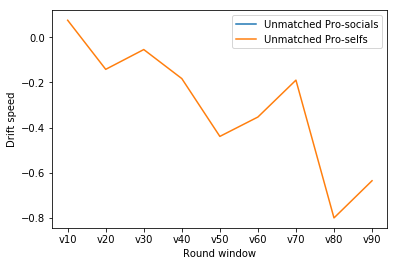

In [25]:
plt.plot(v_un_socials.groupby("variable").mean(), label = "Unmatched Pro-socials")
plt.plot(v_un_selfs.groupby("variable").mean(),  label = "Unmatched Pro-selfs")
plt.xlabel("Round window")
plt.ylabel("Drift speed")
plt.legend()

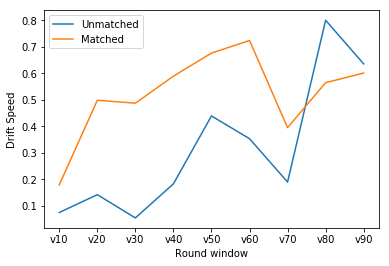

In [26]:
plt.plot(np.abs(v_unmatched.groupby("variable").mean()), label = "Unmatched")
plt.plot(np.abs(v_matched.groupby("variable").mean()),  label = "Matched")
plt.xlabel("Round window")
plt.ylabel("Drift Speed")
plt.legend()

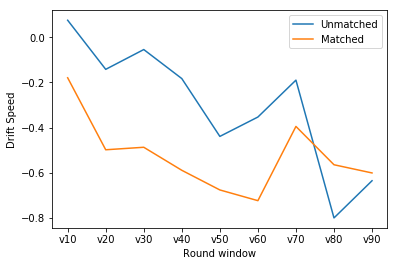

In [27]:
plt.plot(v_unmatched.groupby("variable").mean(), label = "Unmatched")
plt.plot(v_matched.groupby("variable").mean(),  label = "Matched")
plt.xlabel("Round window")
plt.ylabel("Drift Speed")
plt.legend()

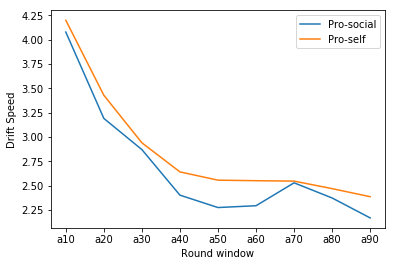

In [29]:
plt.plot(a_socials.groupby("variable").mean(), label = "Pro-social")
plt.plot(a_selfs.groupby("variable").mean(),  label = "Pro-self")
plt.xlabel("Round window")
plt.ylabel("Drift Speed")
plt.legend()

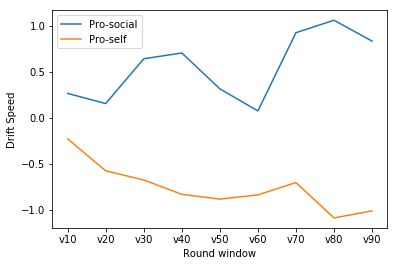

In [28]:
plt.plot(v_socials.groupby("variable").mean(), label = "Pro-social")
plt.plot(v_selfs.groupby("variable").mean(),  label = "Pro-self")
plt.xlabel("Round window")
plt.ylabel("Drift Speed")
plt.legend()

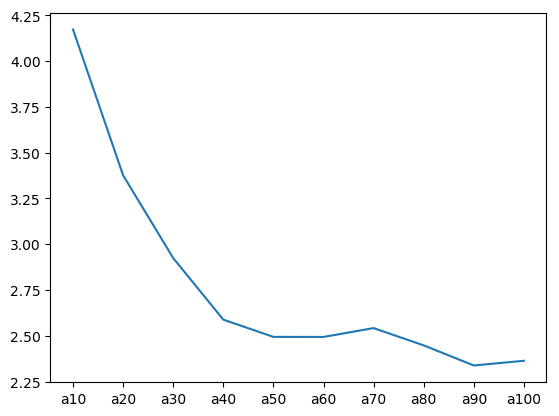

In [20]:
plt.plot(params_chang.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]])

In [19]:
import numpy.matlib
curve = params_chang.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

3

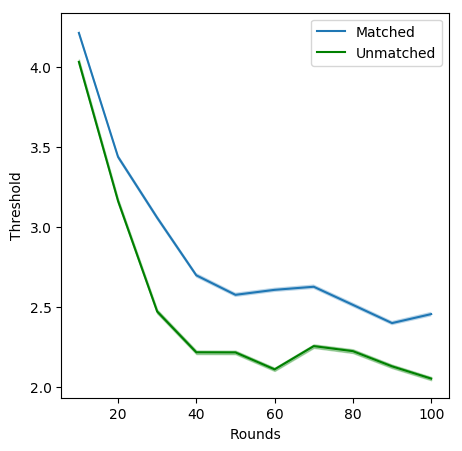

In [21]:
match = get_params("a", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("a", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.a,label = "Matched")
plt.fill_between(match["round"], match.a + (errMatch * 1.96), match.a - (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.a,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.a + (errUnmatch * 1.96), unmatch.a - (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.legend()

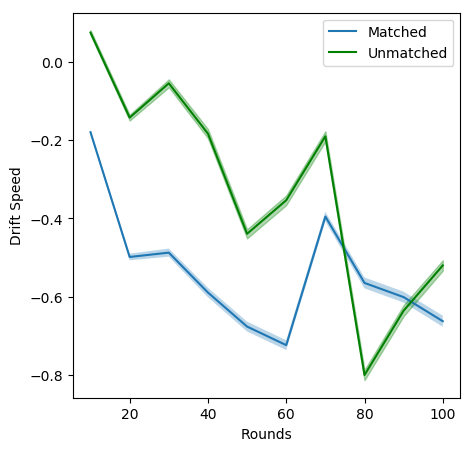

In [22]:
match = get_params("v", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("v", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.v,label = "Matched")
plt.fill_between(match["round"], match.v + (errMatch * 1.96), match.v - (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.v,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.v + (errUnmatch * 1.96), unmatch.v - (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Drift Speed")
plt.legend()

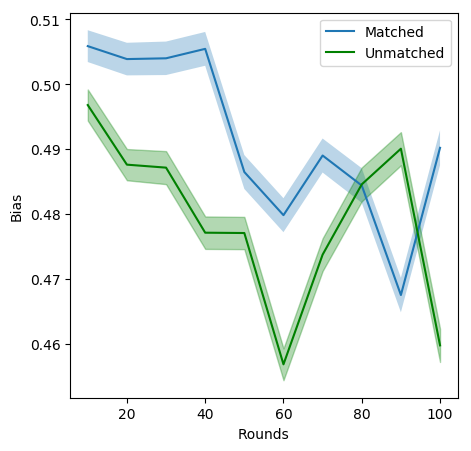

In [23]:
match = get_params("z", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("z", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.z,label = "Matched")
plt.fill_between(match["round"], match.z + (errMatch * 1.96), match.z - (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.z,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.z + (errUnmatch * 1.96), unmatch.z - (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Bias")
plt.legend()